# Preparation

In [2]:
import iminuit
%load_ext line_profiler
import matplotlib.pyplot as plt
%matplotlib inline
import numba
import numpy as np
import pandas as pd
import scipy as sp
from scipy import optimize
import seaborn as sns

sns.set_style('darkgrid')
sns.set_context('notebook')

In [3]:
results = pd.DataFrame()

# Load C14 models

In [4]:
import c14_models

# Read patient data

In [186]:
exp_data = pd.read_pickle('./data/C14data_liver_samples_20180505.pkl')

In [187]:
exp_data.head()

,type,code,sample,Dbirth,Dcoll,d14C,subject_age,valid
0,unsorted,PH1,ND380,1942.833333,2016.416667,0.078416,73.583333,True
1,unsorted,PH2,ND388,1991.416667,2016.833333,0.025254,25.416667,True
2,hepatocyte,PH3,ND381,1985.166667,2016.416667,0.040336,31.250000,True
3,hepatocyte,PH4,ND382,1982.083333,2016.500000,0.018815,34.416667,True
4,hepatocyte,PH6,ND022,1946.500000,2004.833333,0.075001,58.333333,True


In [188]:
exp_data.describe()

,Dbirth,Dcoll,d14C,subject_age
count,82.000000,82.000000,82.000000,82.000000
mean,1962.111789,2016.372967,0.043597,54.261179
std,19.893226,2.980165,0.024579,19.566788
min,1932.583333,2004.833333,0.005100,20.000000
25%,1946.500000,2016.750000,0.026391,37.500000
50%,1958.750000,2017.166667,0.040768,58.250000
75%,1979.833333,2017.416667,0.051775,67.062500
max,1997.333333,2017.583333,0.135400,84.666667


# Plot data 

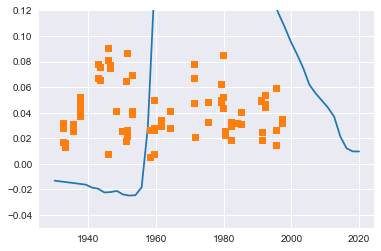

In [189]:
tt = np.linspace(1930, 2020)
plt.plot(tt, np.vectorize(c14_models.C_atm)(tt))
plt.plot(exp_data['Dbirth'], exp_data['d14C'], ls = 'None', marker = 's')
plt.ylim(-0.05, 0.12)
plt.show()

# Individual rates

In [284]:
# @np.vectorize
# def I1(Dbirth, Dcoll, loglam):
#     if loglam <= 10:
#         lam = np.exp(loglam)
#         return c14_models.I1(Dbirth, Dcoll, lam, t_eval=np.linspace(Dbirth, Dcoll))[1][-1]
#     else:
#         return c14_models.C_atm(Dcoll)
    
@np.vectorize
def I1(Dbirth, Dcoll, loglam):
    if loglam <= 10:
        lam = np.exp(loglam)
        return c14_models.C_scenario_A(Dbirth, Dcoll, lam)
    else:
        return c14_models.C_atm(Dcoll)

def diffI1(loglam, data):
    model_data = I1(data['Dbirth'], 
                    data['Dcoll'], 
                    loglam)
    diff = (model_data - data['d14C'])
    return diff

def SSE_individual(p, data):
    model_data = I1(data['Dbirth'], 
                    data['Dcoll'], 
                    p)
    sse = np.sum((model_data - data['d14C'])**2)
    return sse    

def plot_diffI1(loglammin, loglammax, data):
    loglams = np.linspace(loglammin, loglammax)
    diff = np.vectorize(diffI1, excluded=[1])(loglams, data)

    plt.plot(loglams, diff)
    plt.plot([loglammin, loglammax], [0, 0])

def individual_rate(i, loglam0=np.log(0.1)):
    try:
#         return np.exp(sp.optimize.brentq(diffI1, -8, 10, args=exp_data.iloc[i]))
        return np.exp(sp.optimize.newton(diffI1, loglam0, args=([exp_data.iloc[i]])))
    except:
        return np.nan
    
def individual_rate_SSE(i):
    r = np.exp(
            sp.optimize.minimize(
                SSE_individual, np.log(0.1), args=(exp_data.iloc[i]), method='Nelder-Mead'
            )['x'][0]
        )
    return r

## Calculate rates

In [285]:
exp_data['individual_rate'] = [individual_rate_SSE(i) for i in range(len(exp_data))]

In [286]:
exp_data['individual_rate2'] = [individual_rate(i) for i in range(len(exp_data))]

/anaconda3/envs/py3/lib/python3.6/site-packages/scipy/optimize/zeros.py:195: RuntimeWarning: Tolerance of 2763.1134138605994 reached
  warnings.warn(msg, RuntimeWarning)
/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:41: RuntimeWarning: overflow encountered in exp
/anaconda3/envs/py3/lib/python3.6/site-packages/scipy/optimize/zeros.py:195: RuntimeWarning: Tolerance of 364.5936967646262 reached
  warnings.warn(msg, RuntimeWarning)
/anaconda3/envs/py3/lib/python3.6/site-packages/scipy/optimize/zeros.py:195: RuntimeWarning: Tolerance of 15956.064520191963 reached
  warnings.warn(msg, RuntimeWarning)


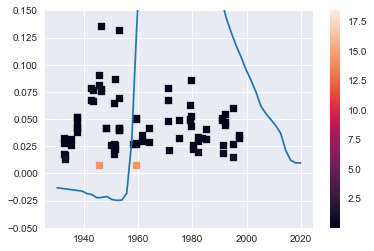

In [287]:
tt = np.linspace(1930, 2020)
plt.plot(tt, np.vectorize(c14_models.C_atm)(tt))
plt.scatter(exp_data['Dbirth'], exp_data['d14C'], marker='s', c=exp_data['individual_rate'])
plt.colorbar()
plt.ylim(-0.05, 0.15)
plt.show()

## Compare to graphical solution

In [144]:
for i, data in exp_data.iterrows():
    plt.figure()
    plot_diffI1(-15, 10, data)
    plt.plot(2*[np.log(data['individual_rate'])], plt.ylim())
    plt.savefig('plots/individual_rate/{}.png'.format(i))
    plt.close()

## Checking the results:

### No nas for SSE:

In [288]:
exp_data[exp_data['individual_rate'].isna()]

,type,code,sample,Dbirth,Dcoll,d14C,subject_age,valid,individual_rate,individual_rate2,cell_age,late


### Some very high rates:

In [289]:
exp_data.query('individual_rate > 2')

,type,code,sample,Dbirth,Dcoll,d14C,subject_age,valid,individual_rate,individual_rate2,cell_age,late
62,hepatocyte,PH79,HL#6,1958.166667,2017.416667,0.0051,59.250000,True,18.445633,inf,NaN,True
64,hepatocyte,PH82,HL#8,1959.333333,2017.500000,0.0074,58.166667,True,14.346246,2.796993e+247,NaN,True
81,HNF4α -,PH107,HL#9,1945.833333,2017.500000,0.0074,71.666667,True,14.346246,0.000000e+00,NaN,True


In [290]:
exp_data.loc[exp_data.query('individual_rate > 2').index, 'individual_rate'] = np.nan

### Very low rates:

In [291]:
exp_data.query('1/individual_rate > 15')

,type,code,sample,Dbirth,Dcoll,d14C,subject_age,valid,individual_rate,individual_rate2,cell_age,late
23,non-hepatocyte,PH32,ND402,1953.0,2017.416667,0.131107,64.416667,True,0.029557,NaN,NaN,True


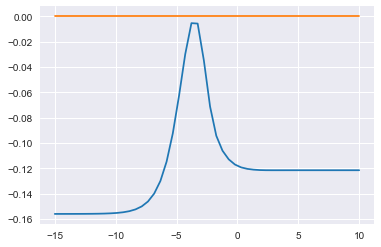

In [292]:
plot_diffI1(-15, 10, exp_data.loc[23])

In [293]:
exp_data.loc[23, 'individual_rate'] = np.nan

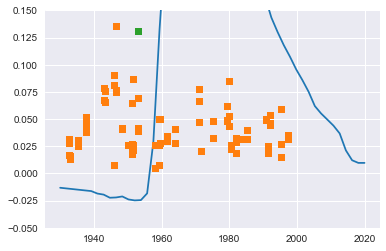

In [294]:
tt = np.linspace(1930, 2020)
plt.plot(tt, np.vectorize(c14_models.C_atm)(tt))
plt.plot(exp_data['Dbirth'], exp_data['d14C'], marker='s', ls='None')
plt.plot(exp_data.loc[23, 'Dbirth'], exp_data.loc[23, 'd14C'], marker='s', ls='None')
plt.ylim(-0.05, 0.15)
plt.show()

One of the pre-bomb guys has this very slow turnover. Why does the other pre-bomb guy not have it?

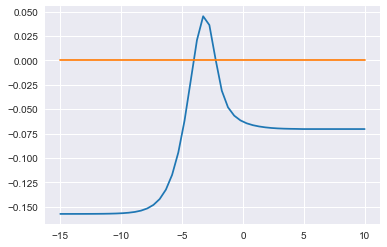

In [295]:
prebomb2 = exp_data.loc[exp_data['d14C'].idxmax()]
plot_diffI1(-15, 10, prebomb2)

### Sanity check of the results by comparing the two methods:

In [296]:
exp_data.query('(individual_rate - individual_rate2)**2 > (1e-3)**2')

,type,code,sample,Dbirth,Dcoll,d14C,subject_age,valid,individual_rate,individual_rate2,cell_age,late


## Analysing results

I use the values obtained with the SSE method.

In [297]:
exp_data['cell_age'] = 1. / exp_data['individual_rate']

In [298]:
exp_data.head()

,type,code,sample,Dbirth,Dcoll,d14C,subject_age,valid,individual_rate,individual_rate2,cell_age,late
0,unsorted,PH1,ND380,1942.833333,2016.416667,0.078416,73.583333,True,0.087163,0.087163,11.472762,True
1,unsorted,PH2,ND388,1991.416667,2016.833333,0.025254,25.416667,True,0.346944,0.346949,2.882313,True
2,hepatocyte,PH3,ND381,1985.166667,2016.416667,0.040336,31.250000,True,0.183505,0.183501,5.449448,True
3,hepatocyte,PH4,ND382,1982.083333,2016.500000,0.018815,34.416667,True,0.730628,0.730632,1.368686,True
4,hepatocyte,PH6,ND022,1946.500000,2004.833333,0.075001,58.333333,True,0.707548,0.707542,1.413332,False


/anaconda3/envs/py3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


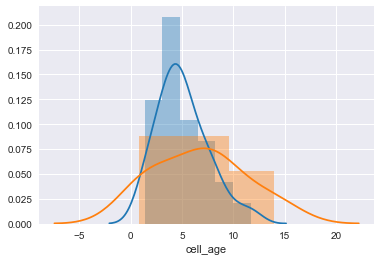

In [299]:
sns.distplot(exp_data.query('valid and type == "hepatocyte"')['cell_age'].dropna())
sns.distplot(exp_data.query('valid and type == "non-hepatocyte"')['cell_age'].dropna())
plt.show()

In [300]:
exp_data[['cell_age', 'subject_age', 'Dbirth', 'Dcoll', 'd14C']].corr()

,cell_age,subject_age,Dbirth,Dcoll,d14C
cell_age,1.000000,-0.034060,0.060338,0.179017,0.694984
subject_age,-0.034060,1.000000,-0.988728,-0.034297,0.032106
Dbirth,0.060338,-0.988728,1.000000,0.183542,-0.106942
Dcoll,0.179017,-0.034297,0.183542,1.000000,-0.503060
d14C,0.694984,0.032106,-0.106942,-0.503060,1.000000


In [301]:
exp_data['late'] = pd.Categorical(exp_data['Dcoll'] > 2015)

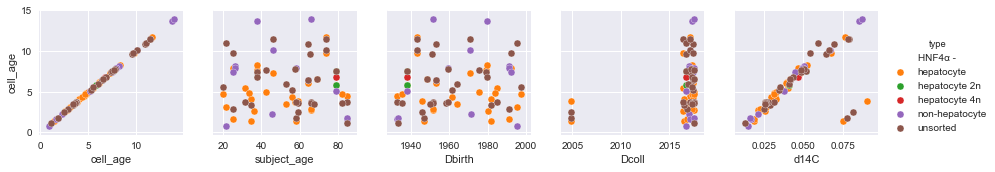

In [302]:
sns.pairplot(exp_data.query('valid'),
            x_vars = ['cell_age', 'subject_age', 'Dbirth', 'Dcoll', 'd14C'],
            y_vars = ['cell_age'],
            hue = 'type')
plt.show()

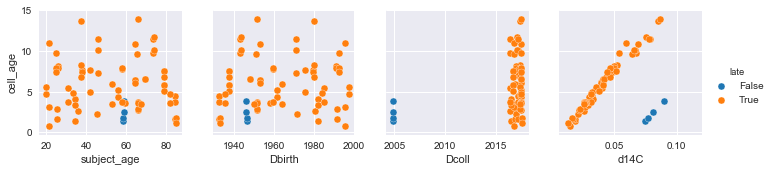

In [303]:
sns.pairplot(exp_data.query('valid'),
            x_vars = ['subject_age', 'Dbirth', 'Dcoll', 'd14C'],
            y_vars = ['cell_age'],
            hue = 'late')
plt.show()

The lately collected samples separate from the early samples. Where does this come from? It should not be the case.

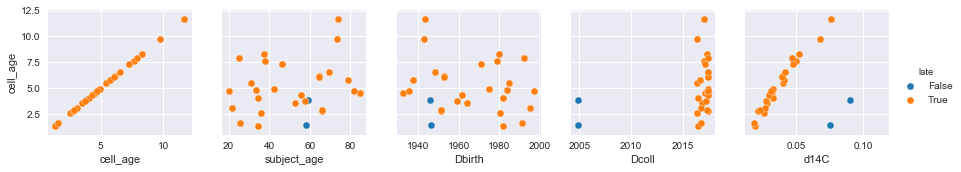

In [304]:
sns.pairplot(exp_data.query('valid and type == "hepatocyte"'),
            x_vars = ['cell_age', 'subject_age', 'Dbirth', 'Dcoll', 'd14C'],
            y_vars = ['cell_age'],
            hue = 'late')
plt.show()

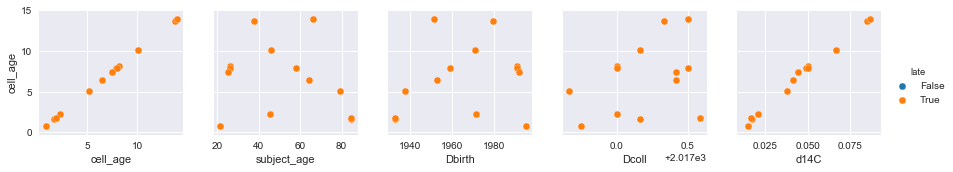

In [305]:
sns.pairplot(exp_data.query('valid and type == "non-hepatocyte"'),
            x_vars = ['cell_age', 'subject_age', 'Dbirth', 'Dcoll', 'd14C'],
            y_vars = ['cell_age'],
            hue = 'late')
plt.show()

## Grouping samples

In [306]:
rate_data = exp_data.query('valid').dropna(
    subset=['cell_age']).groupby(
    ['type', 'code', 'sample']
).mean().dropna(how='all').reset_index()

rate_data['late'] = pd.Categorical(rate_data['Dcoll'] > 2015)

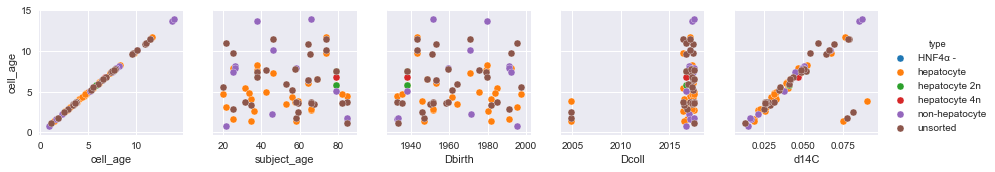

In [307]:
sns.pairplot(rate_data,
            x_vars = ['cell_age', 'subject_age', 'Dbirth', 'Dcoll', 'd14C'],
            y_vars = ['cell_age'],
            hue = 'type')
plt.show()

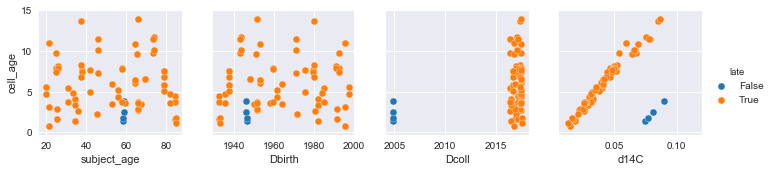

In [308]:
sns.pairplot(rate_data,
            x_vars = ['subject_age', 'Dbirth', 'Dcoll', 'd14C'],
            y_vars = ['cell_age'],
            hue = 'late')
plt.show()

The lately collected samples separate from the early samples.

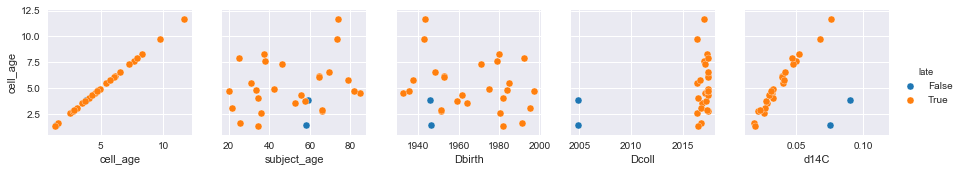

In [309]:
sns.pairplot(rate_data.query('type == "hepatocyte"'),
            x_vars = ['cell_age', 'subject_age', 'Dbirth', 'Dcoll', 'd14C'],
            y_vars = ['cell_age'],
            hue = 'late')
plt.show()

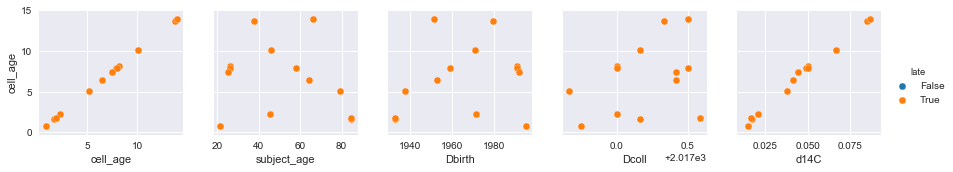

In [310]:
sns.pairplot(rate_data.query('type == "non-hepatocyte"'),
            x_vars = ['cell_age', 'subject_age', 'Dbirth', 'Dcoll', 'd14C'],
            y_vars = ['cell_age'],
            hue = 'late')
plt.show()

# Export

In [314]:
exp_data.to_excel('./write/C14_data.xlsx')